In [1]:
# Imports
import time
import numpy as np
import tensorflow as tf
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
from tf_utils import load_dataset, random_mini_batches, convert_to_one_hot, predict
%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

#np.random.seed(1)

/Users/samshen/anaconda/envs/py36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def sigmoid(Z):
    """
    Implements the sigmoid activation in numpy
    
    Arguments:
    Z -- numpy array of any shape
    
    Returns:
    A -- output of sigmoid(z), same shape as Z
    cache -- returns Z as well, useful during backpropagation
    """
    
    A = 1/(1+np.exp(-Z))
    cache = Z
    
    return A, cache

def relu(Z):
    """
    Implement the RELU function.
    Arguments:
    Z -- Output of the linear layer, of any shape
    Returns:
    A -- Post-activation parameter, of the same shape as Z
    cache -- a python dictionary containing "A" ; stored for computing the backward pass efficiently
    """
    
    A = np.maximum(0,Z)
    
    assert(A.shape == Z.shape)
    
    cache = Z 
    return A, cache
  
def softmax(Z):
    """
    Implement the RELU function.
    Arguments:
    Z -- Output of the linear layer, of any shape
    Returns:
    A -- Post-activation parameter, of the same shape as Z
    cache -- a python dictionary containing "A" ; stored for computing the backward pass efficiently
    """

    Z_exp = np.exp(Z);
    den = np.sum(Z_exp, axis = 0);
    A = Z_exp / den;

    assert(A.shape == Z.shape)

    cache = Z 
    return A, cache


def relu_backward(dA, cache):
    """
    Implement the backward propagation for a single RELU unit.
    Arguments:
    dA -- post-activation gradient, of any shape
    cache -- 'Z' where we store for computing backward propagation efficiently
    Returns:
    dZ -- Gradient of the cost with respect to Z
    """
    
    Z = cache
    dZ = np.array(dA, copy=True) # just converting dz to a correct object.
    
    # When z <= 0, you should set dz to 0 as well. 
    dZ[Z <= 0] = 0
    
    assert (dZ.shape == Z.shape)
    
    return dZ

def sigmoid_backward(dA, cache):
    """
    Implement the backward propagation for a single SIGMOID unit.
    Arguments:
    dA -- post-activation gradient, of any shape
    cache -- 'Z' where we store for computing backward propagation efficiently
    Returns:
    dZ -- Gradient of the cost with respect to Z
    """
    
    Z = cache
    
    s = 1/(1+np.exp(-Z))
    dZ = dA * s * (1-s)
    
    assert (dZ.shape == Z.shape)
    
    return dZ
  
def softmax_backward(Y, Y_hat):
    """
    Implement the backward propagation for a single SIGMOID unit.
    Arguments:
    
    Returns:
    dZ -- Gradient of the cost with respect to Z
    """
    
    dZ = Y_hat - Y
    
    
    return dZ

In [3]:
def initialize_parameters_deep(layer_dims):
    """
    Arguments:
    layer_dims -- python array (list) containing the dimensions of each layer in our network
    
    Returns:
    parameters -- python dictionary containing your parameters "W1", "b1", ..., "WL", "bL":
                    Wl -- weight matrix of shape (layer_dims[l], layer_dims[l-1])
                    bl -- bias vector of shape (layer_dims[l], 1)
    """
    
    np.random.seed(3)
    parameters = {}
    L = len(layer_dims)            # number of layers in the network

    for l in range(1, L):
        ### START CODE HERE ### (≈ 2 lines of code)
        parameters['W' + str(l)] = np.random.randn(layer_dims[l],layer_dims[l-1])*0.01
        parameters['b' + str(l)] = np.zeros((layer_dims[l],1))
        ### END CODE HERE ###
        
        assert(parameters['W' + str(l)].shape == (layer_dims[l], layer_dims[l-1]))
        assert(parameters['b' + str(l)].shape == (layer_dims[l], 1))

        
    return parameters


def linear_forward(A, W, b):
    """
    Implement the linear part of a layer's forward propagation.

    Arguments:
    A -- activations from previous layer (or input data): (size of previous layer, number of examples)
    W -- weights matrix: numpy array of shape (size of current layer, size of previous layer)
    b -- bias vector, numpy array of shape (size of the current layer, 1)

    Returns:
    Z -- the input of the activation function, also called pre-activation parameter 
    cache -- a python dictionary containing "A", "W" and "b" ; stored for computing the backward pass efficiently
    """
    
    ### START CODE HERE ### (≈ 1 line of code)
    Z = np.dot(W,A)+b
    ### END CODE HERE ###
    
    assert(Z.shape == (W.shape[0], A.shape[1]))
    cache = (A, W, b)
    
    return Z, cache

In [4]:
def linear_activation_forward(A_prev, W, b, activation):
    """
    Implement the forward propagation for the LINEAR->ACTIVATION layer

    Arguments:
    A_prev -- activations from previous layer (or input data): (size of previous layer, number of examples)
    W -- weights matrix: numpy array of shape (size of current layer, size of previous layer)
    b -- bias vector, numpy array of shape (size of the current layer, 1)
    activation -- the activation to be used in this layer, stored as a text string: "sigmoid" or "relu"

    Returns:
    A -- the output of the activation function, also called the post-activation value 
    cache -- a python dictionary containing "linear_cache" and "activation_cache";
             stored for computing the backward pass efficiently
    """
    
    if activation == "sigmoid":
        # Inputs: "A_prev, W, b". Outputs: "A, activation_cache".
        ### START CODE HERE ### (≈ 2 lines of code)
        Z, linear_cache = linear_forward(A_prev,W,b)
        A, activation_cache = sigmoid(Z)
        ### END CODE HERE ###
    
    elif activation == "relu":
        # Inputs: "A_prev, W, b". Outputs: "A, activation_cache".
        ### START CODE HERE ### (≈ 2 lines of code)
        Z, linear_cache = linear_forward(A_prev,W,b)
        A, activation_cache = relu(Z)
        ### END CODE HERE ###
    elif activation == "softmax":
        Z, linear_cache = linear_forward(A_prev,W,b)
        A, activation_cache = softmax(Z)
        
    assert (A.shape == (W.shape[0], A_prev.shape[1]))
    cache = (linear_cache, activation_cache)

    return A, cache

In [5]:
def L_model_forward(X, parameters):
    """
    Implement forward propagation for the [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID computation
    
    Arguments:
    X -- data, numpy array of shape (input size, number of examples)
    parameters -- output of initialize_parameters_deep()
    
    Returns:
    AL -- last post-activation value
    caches -- list of caches containing:
                every cache of linear_activation_forward() (there are L-1 of them, indexed from 0 to L-1)
    """

    caches = []
    A = X
    L = len(parameters) // 2                  # number of layers in the neural network
    
    # Implement [LINEAR -> RELU]*(L-1). Add "cache" to the "caches" list.
    for l in range(1, L):
        A_prev = A 
        ### START CODE HERE ### (≈ 2 lines of code)
        A, cache = linear_activation_forward(A_prev, parameters['W' + str(l)], 
                                             parameters['b' + str(l)], "relu")
        caches.append(cache)
        ### END CODE HERE ###
    
    # Implement LINEAR -> SIGMOID. Add "cache" to the "caches" list.
    ### START CODE HERE ### (≈ 2 lines of code)
    AL, cache = linear_activation_forward(A, parameters['W' + str(L)], 
                                          parameters['b' + str(L)], "softmax")
    caches.append(cache)
    ### END CODE HERE ###
    
    #assert(AL.shape == (10,X.shape[1]))
            
    return AL, caches

In [6]:
def compute_cost(AL, Y, cost_function = 'softmax_cross_entropy'):
    """
    Implement the cost function defined by equation (7).

    Arguments:
    AL -- probability vector corresponding to your label predictions, shape (10, number of examples)
    Y -- true "label" vector (for example: [1,0,0,...,0] as 0
         [0,1,0,...,0] as 1), shape (classes, number of examples)

    Returns:
    cost -- cross-entropy cost
    """
    
    m = Y.shape[1]

    # Compute loss from aL and y.
    ### START CODE HERE ### (≈ 1 lines of code)
    if cost_function == 'softmax_cross_entropy':
        cost = (-1/m) * np.sum(Y*np.log(AL))
    elif cost_function == 'sigmoid_cross_entropy':
        cost = -1/m*np.sum(Y*np.log(AL)+(1-Y)*np.log(1-AL))
    
    ### END CODE HERE ###
    
    cost = np.squeeze(cost)      # To make sure your cost's shape is what we expect (e.g. this turns [[17]] into 17).
    assert(cost.shape == ())
    
    return cost

In [7]:
def linear_backward(dZ, cache):
    """
    Implement the linear portion of backward propagation for a single layer (layer l)

    Arguments:
    dZ -- Gradient of the cost with respect to the linear output (of current layer l)
    cache -- tuple of values (A_prev, W, b) coming from the forward propagation in the current layer

    Returns:
    dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
    dW -- Gradient of the cost with respect to W (current layer l), same shape as W
    db -- Gradient of the cost with respect to b (current layer l), same shape as b
    """
    A_prev, W, b = cache
    m = A_prev.shape[1]

    ### START CODE HERE ### (≈ 3 lines of code)
    dW = 1/m*np.dot(dZ,A_prev.T)
    db = 1/m*np.sum(dZ,axis=1,keepdims=True)
    dA_prev = np.dot(W.T,dZ)
    ### END CODE HERE ###
    
    assert (dA_prev.shape == A_prev.shape)
    assert (dW.shape == W.shape)
    assert (db.shape == b.shape)
    
    return dA_prev, dW, db

In [8]:
def linear_activation_backward(dA, cache, Y, Y_hat, activation):
    """
    Implement the backward propagation for the LINEAR->ACTIVATION layer.
    
    Arguments:
    dA -- post-activation gradient for current layer l 
    cache -- tuple of values (linear_cache, activation_cache) we store for computing backward propagation efficiently
    activation -- the activation to be used in this layer, stored as a text string: "sigmoid" or "relu"
    
    Returns:
    dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
    dW -- Gradient of the cost with respect to W (current layer l), same shape as W
    db -- Gradient of the cost with respect to b (current layer l), same shape as b
    """
    linear_cache, activation_cache = cache
    
    if activation == "relu":
        ### START CODE HERE ### (≈ 2 lines of code)
        dZ = relu_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ,linear_cache)
        ### END CODE HERE ###
        
    elif activation == "sigmoid":
        ### START CODE HERE ### (≈ 2 lines of code)
        dZ = sigmoid_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ,linear_cache)
        ### END CODE HERE ###
    elif activation == "softmax":
        ### START CODE HERE ### (≈ 2 lines of code)
        dZ = softmax_backward(Y, Y_hat)
        dA_prev, dW, db = linear_backward(dZ,linear_cache)
        ### END CODE HERE ###
    
    return dA_prev, dW, db

In [9]:
def L_model_backward(AL, Y, caches):
    """
    Implement the backward propagation for the [LINEAR->RELU] * (L-1) -> LINEAR -> SIGMOID group
    
    Arguments:
    AL -- probability vector, output of the forward propagation (L_model_forward())
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat)
    caches -- list of caches containing:
                every cache of linear_activation_forward() with "relu" (it's caches[l], for l in range(L-1) i.e l = 0...L-2)
                the cache of linear_activation_forward() with "sigmoid" (it's caches[L-1])
    
    Returns:
    grads -- A dictionary with the gradients
             grads["dA" + str(l)] = ... 
             grads["dW" + str(l)] = ...
             grads["db" + str(l)] = ... 
    """
    grads = {}
    L = len(caches) # the number of layers
    m = AL.shape[1]
    Y = Y.reshape(AL.shape) # after this line, Y is the same shape as AL
    
    # Initializing the backpropagation
    ### START CODE HERE ### (1 line of code)
    dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL)) 
    ### END CODE HERE ###
    
    # Lth layer (SIGMOID -> LINEAR) gradients. Inputs: "dAL, current_cache". Outputs: "grads["dAL-1"], grads["dWL"], grads["dbL"]
    ### START CODE HERE ### (approx. 2 lines)
    current_cache = caches[L-1]
    #grads["dA" + str(L-1)], grads["dW" + str(L)], grads["db" + str(L)] = linear_activation_backward(dAL, current_cache, 'sigmoid')
    grads["dA" + str(L-1)], grads["dW" + str(L)], grads["db" + str(L)] = linear_activation_backward(dAL, current_cache, Y, AL, 'softmax')
    ### END CODE HERE ###
    
    # Loop from l=L-2 to l=0
    for l in reversed(range(L-1)):
        # lth layer: (RELU -> LINEAR) gradients.
        # Inputs: "grads["dA" + str(l + 1)], current_cache". Outputs: "grads["dA" + str(l)] , grads["dW" + str(l + 1)] , grads["db" + str(l + 1)] 
        ### START CODE HERE ### (approx. 5 lines)
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA" + str(l+1)], current_cache, Y, AL, 'relu')
        grads["dA" + str(l)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp
        ### END CODE HERE ###

    return grads

In [10]:
def update_parameters(parameters, grads, learning_rate):
    """
    Update parameters using gradient descent
    
    Arguments:
    parameters -- python dictionary containing your parameters 
    grads -- python dictionary containing your gradients, output of L_model_backward
    
    Returns:
    parameters -- python dictionary containing your updated parameters 
                  parameters["W" + str(l)] = ... 
                  parameters["b" + str(l)] = ...
    """
    
    L = len(parameters) // 2 # number of layers in the neural network

    # Update rule for each parameter. Use a for loop.
    ### START CODE HERE ### (≈ 3 lines of code)
    for l in range(L):
        parameters["W" + str(l+1)] -= learning_rate * grads['dW'+str(l+1)]
        parameters["b" + str(l+1)] -= learning_rate * grads['db'+str(l+1)]
    ### END CODE HERE ###
    return parameters

In [11]:
def one_hot_label(classes, label):
    """
    reshape label to Sam prefered shape for mnist

    Arguments:
    label -- input label with shape (m,)

    Returns:
    new_label -- output label with shape (10, 1, m)
    """
    m = label.shape[0]
    new_label = np.zeros((classes, m))
    for i in range(m):
        clas = label[i]
        new_label[clas,i] = 1
    return new_label


In [12]:
train_data_orig, train_labels_orig, eval_data_orig, eval_labels_orig, classes = load_dataset()
classes = 6
train_labels = np.squeeze(train_labels_orig)
train_labels_old = train_labels
train_labels = one_hot_label(classes, train_labels_old)
eval_labels = np.squeeze(eval_labels_orig)
eval_labels_old = eval_labels
eval_labels = one_hot_label(classes, eval_labels_old)
# Flatten the training and test images
train_data = train_data_orig.reshape(train_data_orig.shape[0], -1).T
eval_data = eval_data_orig.reshape(eval_data_orig.shape[0], -1).T
# Normalize image vectors
train_data = train_data/255.
eval_data = eval_data/255.
features = train_data.shape[0]
print(train_data.shape)

(12288, 1080)


In [241]:
# Load training and eval data
mnist = tf.contrib.learn.datasets.load_dataset("mnist")
train_data = mnist.train.images.T # Returns np.array
classes = 10
train_labels = np.asarray(mnist.train.labels, dtype=np.int32)
train_labels = one_hot_label(classes, train_labels)
eval_data = mnist.test.images.T # Returns np.array
eval_labels_old = np.asarray(mnist.test.labels, dtype=np.int32)
eval_labels = one_hot_label(classes, eval_labels_old)
features = train_data.shape[0]
print(train_data.shape)

Extracting MNIST-data/train-images-idx3-ubyte.gz
Extracting MNIST-data/train-labels-idx1-ubyte.gz
Extracting MNIST-data/t10k-images-idx3-ubyte.gz
Extracting MNIST-data/t10k-labels-idx1-ubyte.gz
(784, 55000)


In [94]:
train_data.shape

(784, 55000)

In [13]:
def L_layer_model(X, Y, layers_dims, parameters = {}, batch_size = 64, learning_rate = 0.0075, num_iterations = 3000, print_cost=False):#lr was 0.009
    """
    Implements a L-layer neural network: [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID.
    
    Arguments:
    X -- data, numpy array of shape (number of examples, num_px * num_px * 3)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples)
    layers_dims -- list containing the input size and each layer size, of length (number of layers + 1).
    learning_rate -- learning rate of the gradient descent update rule
    num_iterations -- number of iterations of the optimization loop
    print_cost -- if True, it prints the cost every 100 steps
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """

    #np.random.seed(1)
    costs = []                         # keep track of cost
    
    # Parameters initialization. (≈ 1 line of code)
    if len(parameters) == 0:
        parameters = initialize_parameters_deep(layers_dims)
    m = X.shape[1]
    num_batchs = m // batch_size
    
    
    # Loop (gradient descent)
    for i in range(0, num_iterations):
        for j in range(num_batchs):
            # Forward propagation: [LINEAR -> RELU]*(L-1) -> LINEAR -> SIGMOID.
            # AL is the output and caches contains Z, A, W, b for each layer
            AL, caches = L_model_forward(X[:, j*batch_size:(j+1)*batch_size], parameters)
            # Compute cost.
            cost = compute_cost(AL,Y[:, j*batch_size:(j+1)*batch_size])
            # Backward propagation.
            grads = L_model_backward(AL, Y[:, j*batch_size:(j+1)*batch_size], caches)
            # Update parameters.
            parameters = update_parameters(parameters, grads, learning_rate)
            # Print the cost every 30 training example
            if print_cost and j % 1 == 0:
                print ("Cost after iteration %i, batch %i: %f" %(i, j, cost))
            if print_cost and j % 5 == 0:
                costs.append(cost)
        if print_cost and i % 1 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
#         if print_cost and i % 5 == 0:
#             costs.append(cost)
    # plot the cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

In [14]:
print(train_data.shape)
print(train_labels.shape)

(12288, 1080)
(6, 1080)


In [87]:
# training model
layers_dims = [features, 4096, 4096, 12, classes] #  2-layer model
parameters = L_layer_model(train_data, train_labels, layers_dims, batch_size = 512, learning_rate = 0.01, num_iterations = 5, print_cost = True)

Cost after iteration 0, batch 0: 1.791746
Cost after iteration 0, batch 1: 1.791700
Cost after iteration 0: 1.791700
Cost after iteration 1, batch 0: 1.791734
Cost after iteration 1, batch 1: 1.791695
Cost after iteration 1: 1.791695


KeyboardInterrupt: 

In [ ]:
# further training on the same model 
parameters = L_layer_model(train_data, train_labels, layers_dims, batch_size = 512, parameters = parameters, learning_rate = 0.5, num_iterations = 5, print_cost = True)

In [16]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [17]:
def eval_model(X, y, parameters):
    """
    This function is used to predict the results of a  L-layer neural network.
    
    Arguments:
    X -- data set of examples you would like to label
    parameters -- parameters of the trained model
    
    Returns:
    p -- predictions for the given dataset X
    """
    
    m = X.shape[1]
    n = len(parameters) // 2 # number of layers in the neural network
    p = np.zeros((y.shape[0],m))
    
    # Forward propagation
    probas, caches = L_model_forward(X, parameters)

    
    # convert probas to 0/1 predictions
    for i in range(probas.shape[0]):
        for j in range(probas.shape[1]):
            if probas[i,j] == np.max(probas[:,j]):
                p[i,j] = 1
            else:
                p[i,j] = 0
    
    #print results
    #print ("predictions: " + str(probas))
    #print ("predictions: " + str(p))
    #print ("true labels: " + str(y))
    match = 0
    for i in range(m):
        match += int(np.array_equal(p[:,i],y[:,i]))
    print("Accuracy: "  + str(np.sum(match*1.0/m)))
        
    return p

In [65]:
def predict(X, parameters):
    """
    This function is used to predict the results of a  L-layer neural network.
    
    Arguments:
    X -- data set of examples you would like to label
    parameters -- parameters of the trained model
    
    Returns:
    p -- predictions for the given dataset X
    """
    m = X.shape[1]
    n = len(parameters) // 2 # number of layers in the neural network
    p = np.zeros((1,m))
    
    # Forward propagation
    probas, caches = L_model_forward(X, parameters)

    
    # convert probas to 0/1 predictions
    for i in range(probas.shape[0]):
        for j in range(probas.shape[1]):
            if probas[i,j] == np.max(probas[:,j]):
                p[0,j] = i
    
    #print results
    #print ("predictions: " + str(probas))
    print ("predictions: " + str(int(np.squeeze(p))))
    #print ("true labels: " + str(y))
    return

In [66]:
eval_model(train_data, train_labels, parameters)
eval_model(eval_data, eval_labels, parameters)

Accuracy: 0.7388888888888889


array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 1.],
       [1., 0., 0., ..., 0., 0., 0.]])

Accuracy: 0.675


array([[1., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0.,
        1., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1.,
        1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 1., 0., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0.,
        0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1.,

predictions: 4
actual value: 3


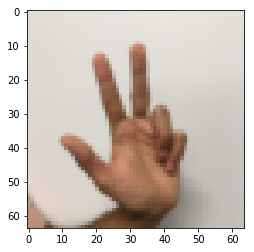

In [81]:
image_num = 61
predict(eval_data[:,image_num:image_num+1],parameters)
#print("actual value: " + str(eval_labels_old[image_num]))
print("actual value: " + str(np.squeeze(train_labels_orig[:, image_num])))
#data = mnist.test.images[image_num].reshape(28,28)
data = train_data_orig[image_num]
plt.imshow(data)